In [1]:
import sys
sys.path.append('..')

In [2]:
import numpy as np
import electrode2currentmap as e2cm
import effectivecurrent2brightness as ec2b
import utils
from utils import TimeSeries
from scipy.signal import fftconvolve
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
# Create a Retina object that can hold the entire Argus I array (4x4 checkerboard, 880um center-to-center)
# width: 4 x 880um = 3520um, but add radii: 3520um + 130um + 260um = 3910 um, but add padding for current spread -> 5000um
r_sampling = 50  # spatial sampling of retina
r = e2cm.Retina(axon_map='../retina_argus_s' + str(r_sampling) + '.npz', 
                sampling=r_sampling, xlo=-2500, xhi=2500, ylo=-2500, yhi=2500)

In [4]:
# Create Argus I electrode array 
# 4x4 checkerboard, 880um center-to-center, (almost) alternating electrode sizes

e_spacing = 880  # um
x_coord = np.arange(0, 4) * e_spacing - 1.5 * e_spacing
x_coord, y_coord = np.meshgrid(x_coord, x_coord, sparse=False)

# spatial arrangement of Argus I creates checkerboard with alternating electrode sizes
#   .  o  .  o
#   o  .  o  .
#   .  o  .  o
#   o  .  o  .
r_arr = np.array([260, 520, 260, 520])
r_arr = np.concatenate((r_arr, r_arr[::-1], r_arr, r_arr[::-1]), axis=0)
h_arr = np.ones(16)*0

e_all = e2cm.ElectrodeArray(r_arr.tolist(), x_coord.flatten().tolist(), y_coord.flatten().tolist(), h_arr.tolist())

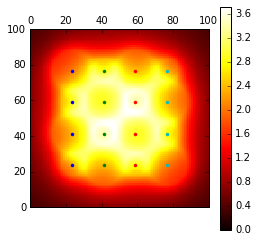

In [5]:
# show the cumulative current spread of the Argus I electrode arrangement
plt.matshow(e_all.current_spread(r.gridx, r.gridy), vmin=0, cmap='hot')

# also plot the center points of all the electrodes
plt.plot(x_coord/r_sampling+r.gridx.shape[0]/2, y_coord/r_sampling+r.gridx.shape[0]/2, '.')

plt.axis([0, r.gridx.shape[0], 0, r.gridx.shape[1]])
plt.colorbar()

In [6]:
e_rf = []
for e in e_all.electrodes:
    e_rf.append(e2cm.receptive_field(e, r.gridx, r.gridy, e_spacing))

In [7]:
# We derive the effective current stimulation (ecs; passed through the effect of the retinal layout, axons, etc.) 
# in addition to the current (cs):
ecs, cs  = r.electrode_ecs(e_all)

In [8]:
# create some pulse train
freq=20
dur=0.5
pulse_dur=.075/1000.
interphase_dur=.075/1000.
tsample=.005/1000.
current_amplitude=20,

p2pt = e2cm.Psycho2Pulsetrain(freq=freq, 
                              dur=dur, 
                              pulse_dur=pulse_dur, 
                              interphase_dur=interphase_dur, 
                              delay=0, 
                              tsample=tsample, 
                              current_amplitude=current_amplitude,
                              pulsetype='cathodicfirst',
                              stimtype='pulsetrain')

fps = 30
rs = 1/(fps*p2pt.tsample)

In [9]:
# The temporal model contains the cascade of operations that leads from pulse to percept:
tm = ec2b.TemporalModel(tsample=tsample)

In [10]:
# csvfile = '../../data/Horsager_2011/DataSummary_Horsager2011.csv'
# data = np.genfromtxt(csvfile, delimiter=',', dtype=None)

In [11]:
# pulse2percept(temporal_model, ecs, retina, stimuli, rs, dojit=True, n_jobs=-1, tol=.05)
%prun mov = ec2b.pulse2percept(tm, ecs, r, [p2pt], int(rs), n_jobs=8, dojit=False, tol=0.01)

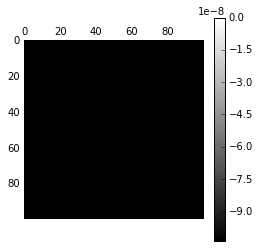

In [12]:
plt.matshow(mov.data[:, :, 10], cmap='gray', vmin=0)
plt.colorbar()